In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
import immigration_data
import xgboost as xgb
import get_best_xgb_model


Read in the data. I am showing the correction applied to take out long term average population growth in order to assess patters of population change over and above secular growth trends. Thus, I run the routine with "remove_trend = False"

In [2]:
imm = immigration_data.immigration_data()
pop = imm.read_population(remove_trend = False)

In [3]:
col_name = []
year = np.arange(16)+2002
for yy in year:
    col_name.append(str(yy) + '_mean')        
        
avg_pop = pop[col_name].sum()/pop[col_name[-1]].sum()
ll = np.polyfit(year, avg_pop, 1)

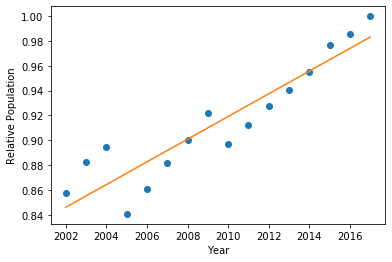

In [4]:
fig = plot.plot(year, avg_pop, '.', markersize = 12)
plot.plot(year, ll[0]*year + ll[1])
plot.xlabel('Year')
plot.ylabel('Relative Population')

plot.savefig('/Users/jabran/Desktop/pop_growth.pdf')

Re-read the data, correcting for secular growth trend. Here I am showing an example of the target. The model regression model tries to fit the relationship between the features and the relative change in population which is plotted below. The  coherent spatial patters indicate migration. The figure below is the logarithm of the population in 2017 relative to population in 2016. 

In [5]:
pop = imm.read_population()
pop2017 = pop['2017_mean']
pop2016 = pop['2016_mean']
xx = pop['left']
yy = pop['top']
dp = (pop2017 )/pop2016

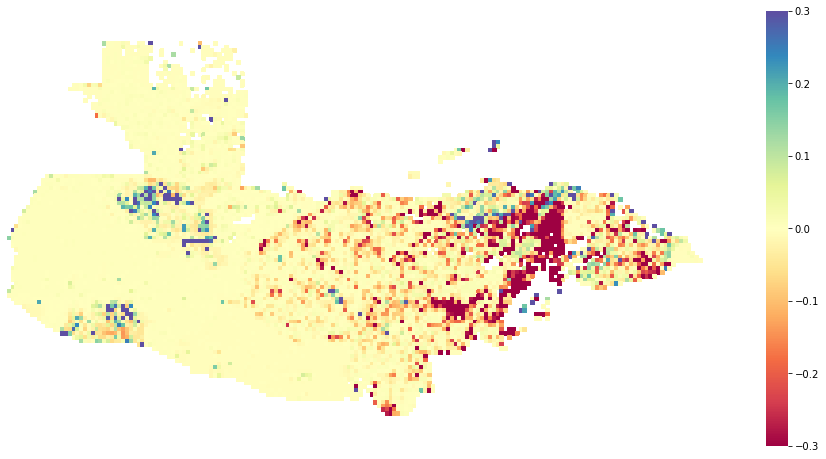

In [6]:
data = pd.DataFrame(data={'x':-yy, 'y':xx, 'z':np.log10(dp)})
data = data.pivot(index='x', columns='y', values='z')

fig = plot.figure(figsize=(16, 8))
#fig.patch.set_facecolor('xkcd:black')
ax = sns.heatmap(data, square = True, cmap = 'Spectral', xticklabels = False, yticklabels = False, vmin = -0.3, vmax = 0.3)
ax.set_ylabel('')
ax.set_xlabel('')
#ax.set_facecolor('xkcd:black')
plot.savefig('/Users/jabran/Desktop/delta_pop_map.pdf')
plot.show()


Read in data and train the XGBoost model that was hyper parameter optimized (see xgboost_optimize.ipynb).

In [9]:
X, y, d = imm.get_training_data()
reg = get_best_xgb_model.get_best_xgb_model()
reg.fit(X,y)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.12999999999999998, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=46, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8779937359366555, verbosity=1)

Here I generate the feature importance plot for the particular model I developed and tuned as shown in xgboost_optimize.ipynb. This plot is specific to that model and has to be remade if model changes.

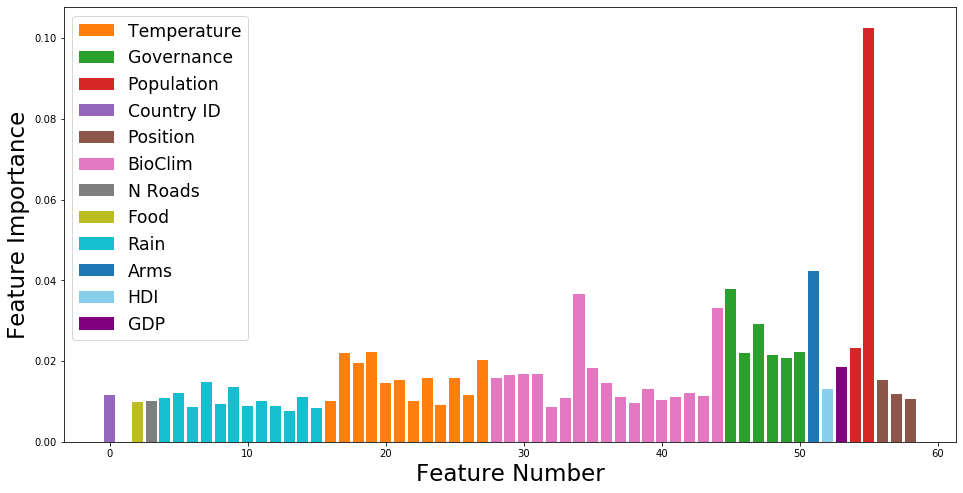

In [10]:
plot.figure(figsize=(16, 8))
plot.bar(range(len(reg.feature_importances_)), reg.feature_importances_)
irain = np.where(d == 'Rain')[0]
itemp = np.where(d == 'Temperature')[0]
ibio = np.where(d == 'BioClim')[0]
igov = np.where(d == 'Government Vector')[0]
ihdi = np.where(d == 'HDI')[0]
igdp = np.where(d == 'GDP')[0]
ipop = np.where((d == 'Population') | (d =='Relative change in Population') )[0]
ipos = np.where(  (d == 'lat') | (d =='lon') | (d == 'id') )[0]
iarm = np.where(d == 'Arms')[0]
inro = np.where(d == 'N Roads')[0]
ifoo = np.where(d == 'Food')[0]
plot.bar(np.arange(len(reg.feature_importances_))[itemp], reg.feature_importances_[itemp], label='Temperature')
plot.bar(np.arange(len(reg.feature_importances_))[igov], reg.feature_importances_[igov], label='Governance')
plot.bar(np.arange(len(reg.feature_importances_))[ipop], reg.feature_importances_[ipop], label='Population')
plot.bar(np.arange(len(reg.feature_importances_))[0], reg.feature_importances_[0], label='Country ID')
plot.bar(np.arange(len(reg.feature_importances_))[ipos], reg.feature_importances_[ipos], label='Position')
plot.bar(np.arange(len(reg.feature_importances_))[ibio], reg.feature_importances_[ibio], label='BioClim')
plot.bar(np.arange(len(reg.feature_importances_))[inro], reg.feature_importances_[inro], label='N Roads')
plot.bar(np.arange(len(reg.feature_importances_))[ifoo], reg.feature_importances_[ifoo], label='Food')
plot.bar(np.arange(len(reg.feature_importances_))[irain], reg.feature_importances_[irain], label='Rain')
plot.bar(np.arange(len(reg.feature_importances_))[iarm], reg.feature_importances_[iarm], label='Arms')
plot.bar(np.arange(len(reg.feature_importances_))[ihdi], reg.feature_importances_[ihdi], label='HDI', color='skyblue')
plot.bar(np.arange(len(reg.feature_importances_))[igdp], reg.feature_importances_[igdp], label='GDP', color='purple')

plot.legend(fontsize= 'xx-large')
plot.xlabel('Feature Number',fontsize=23)
plot.ylabel('Feature Importance', fontsize=23)
plot.savefig('/Users/jabran/Desktop/feature_importance.pdf')
plot.show()

I find the six most important features for illustrating the potential uses of such a model.

In [11]:
ind_imp = np.argsort(reg.feature_importances_)[-6:]
d[ind_imp]
imp = reg.feature_importances_[ind_imp]

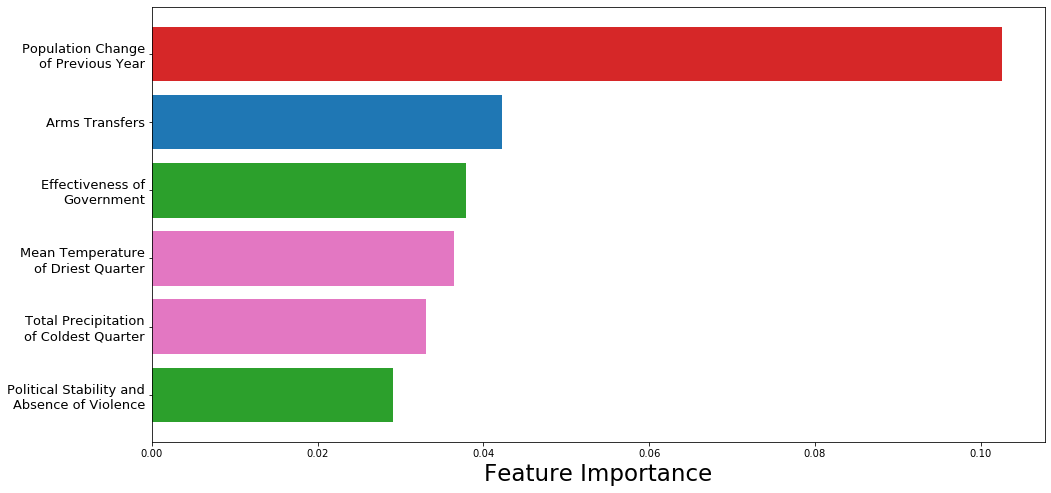

In [12]:
fff = plot.figure(figsize=(16, 8))
plot.barh(range(len(ind_imp)), reg.feature_importances_[ind_imp])
plot.barh([0],reg.feature_importances_[ind_imp[0]], color= u'#2ca02c' )
plot.barh([3],reg.feature_importances_[ind_imp[3]], color= u'#2ca02c' )
plot.barh([1],reg.feature_importances_[ind_imp[1]], color= u'#e377c2' )
plot.barh([2],reg.feature_importances_[ind_imp[2]], color= u'#e377c2' )
plot.barh([5],reg.feature_importances_[ind_imp[5]], color= u'#d62728')
ytickname = ['Political Stability and\nAbsence of Violence', 
             'Total Precipitation\nof Coldest Quarter', 
             'Mean Temperature\nof Driest Quarter', 
             'Effectiveness of\nGovernment', 
             'Arms Transfers', 
             'Population Change\nof Previous Year']
plot.yticks(np.arange(6), ytickname, ha ='right', fontsize=13, wrap=True)
#plot.legend(fontsize= 'xx-large')
plot.xlabel('Feature Importance', fontsize=23)
plot.savefig('/Users/jabran/Desktop/feature_importance_sub.pdf')
plot.show()